In [1]:
# %%
import os, sys, importlib, time, json
import numpy as np
import torch

print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.version.cuda)
print("GPU   :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

# 프로젝트 루트가 현재가 아니라면 아래처럼 경로 추가
# sys.path.append("/path/to/your/project")

# 0) 패키지 세팅
from pathlib import Path
import sys, importlib

PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

# 2) 올바른 임포트 (패키지 경로 사용)
import utils as utils
import model as model
import data_loader as data_loader

importlib.reload(utils)
importlib.reload(model)
importlib.reload(data_loader)

from src.model import convnextv2_atto, convnextv2_nano, convnextv2_tiny
from src.data_loader import get_dataloaders, LensFITSBinaryDataset

print("✅ imports via 'src.*' ready")



Python: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 17:29:18) [GCC 11.2.0]
Torch : 2.6.0+cu124
CUDA  : 12.4
GPU   : Quadro RTX 5000


/home/users/mmingyeong/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ imports via 'src.*' ready


In [2]:
import predict as predict  # predict.py 모듈 임포트
import evaluate as evaluate  # evaluate.py 임포트

In [3]:
# %%
import types, sys, os, json
from pathlib import Path
import torch
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 프로젝트 경로
# -----------------------
PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

import predict
import evaluate

# -----------------------
# 데이터 경로
# -----------------------
SLSIM_LENSES_DIR      = "/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses"
SLSIM_NONLENSES_DIR   = "/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses"
HSC_DEG_LENSES_DIR    = "/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses"
HSC_DEG_NONLENSES_DIR = "/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses"

# -----------------------
# 실험 루트 (학습 시 생성된 타임스탬프 폴더로 교체)
# -----------------------
BASE_SAVE_DIR = PROJECT_ROOT / "_pilot_ckpt_20250905_162614"

# -----------------------
# 스무딩 하이퍼파라미터 (predict에도 동일 적용)
# -----------------------
CLIP_Q         = 0.997      # 정규화 상위 분위수 클리핑(음수면 off)
GAUSS_SIGMA    = 0.8        # 가우시안 sigma [pixel]
GUIDED_RADIUS  = 2          # guided filter radius [pixel]
GUIDED_EPS     = 1e-2       # guided filter eps (intensity^2)

# -----------------------
# 세 가지 스무딩 모드 실험 폴더
# (학습 시 저장된 디렉토리명과 정확히 일치해야 함)
# -----------------------
EXPERIMENTS = {
    "sm_none_norm1_pad0":     BASE_SAVE_DIR / "sm_none_norm1_pad0",
    "sm_gaussian_norm1_pad0": BASE_SAVE_DIR / "sm_gaussian_norm1_pad0",
    "sm_guided_norm1_pad0":   BASE_SAVE_DIR / "sm_guided_norm1_pad0",
}

# 스무딩 이름에 따른 predict 인자 매핑
def smoothing_kwargs(tag: str):
    if "sm_none" in tag:
        return dict(smoothing_mode="none")
    if "sm_gaussian" in tag:
        return dict(smoothing_mode="gaussian", gaussian_sigma=GAUSS_SIGMA)
    if "sm_guided" in tag:
        return dict(smoothing_mode="guided", guided_radius=GUIDED_RADIUS, guided_eps=GUIDED_EPS)
    # 기본값 (혹시 태그가 다르면 none으로)
    return dict(smoothing_mode="none")

RESULTS = []

# -----------------------
# predict + evaluate 반복
# -----------------------
for tag, ckpt_dir in EXPERIMENTS.items():
    print(f"=== Running {tag} ===")
    out_pred_dir = ckpt_dir / "pred_outputs"
    out_eval_dir = ckpt_dir / "eval_outputs"
    out_pred_dir.mkdir(parents=True, exist_ok=True)
    out_eval_dir.mkdir(parents=True, exist_ok=True)

    # ---------- predict ----------
    sm_kw = smoothing_kwargs(tag)
    args_pred = types.SimpleNamespace(
        # 데이터 경로 / 분할
        slsim_lenses       = SLSIM_LENSES_DIR,
        slsim_nonlenses    = SLSIM_NONLENSES_DIR,
        hsc_lenses         = HSC_DEG_LENSES_DIR,
        hsc_nonlenses      = HSC_DEG_NONLENSES_DIR,
        which              = "test",
        batch_size         = 64,
        num_workers        = 4,
        train_frac         = 0.70,
        val_frac           = 0.15,
        test_frac          = 0.15,
        seed               = 42,
        take_test_fraction = 0.01,  # 속도용 샘플링(정식 평가 시 None 권장)

        # 모델 체크포인트
        model_path         = str(ckpt_dir / "best.pt"),
        model_size         = "atto",
        drop_path          = 0.0,

        # 디바이스 & 출력
        device             = "cuda" if torch.cuda.is_available() else "cpu",
        output_dir         = str(out_pred_dir),

        # ⚙️ 전처리 토글 (학습과 동일하게!)
        apply_padding      = False,          # pad off
        out_size_when_padded = 64,           # pad off라 무시
        apply_normalization = True,          # norm on
        clip_q             = CLIP_Q,         # (음수면 off)
        low_clip_q         = None,
        use_mad            = False,

        # 스무딩 옵션
        **sm_kw,
    )
    predict.main(args_pred)

    # ---------- evaluate ----------
    args_eval = types.SimpleNamespace(
        tag=tag,
        from_csv=False,
        from_npy=True,
        csv=None,
        labels=str(out_pred_dir / "labels_test.npy"),
        probs=str(out_pred_dir / "probs_test.npy"),
        preds=str(out_pred_dir / "preds_test.npy"),
        threshold=0.5,
        optimize_threshold=True,   # 최적 threshold (Youden J)도 산출/저장
        per_domain=False,
        plot=True,
        out_dir=str(out_eval_dir),
        seed=42,
    )
    evaluate.main(args_eval)

    # ---------- 결과 수집 (유연하게 여러 파일명 대응) ----------
    # 우선 evaluate가 results_{tag}.json을 썼다고 가정
    candidates = [
        out_eval_dir / f"results_{tag}.json",
        out_eval_dir / "results.json",
        out_eval_dir / f"metrics_{tag}.json",
        out_eval_dir / "metrics.json",
    ]
    res_path = next((p for p in candidates if p.exists()), None)
    if res_path is not None:
        with open(res_path) as f:
            res = json.load(f)
        RESULTS.append({"mode": tag, **res})
    else:
        # 없으면 최소한 존재 여부 로그
        print(f"[WARN] No results JSON found in {out_eval_dir}. "
              f"Checked: {[str(p) for p in candidates]}")

# (선택) DataFrame으로 한 번에 확인
if RESULTS:
    df = pd.DataFrame(RESULTS)
    display(df)


2025-09-05 20:20:16,986 [INFO] [predict] 📦 Building dataloaders...


=== Running sm_none_norm1_pad0 ===


2025-09-05 20:20:17,850 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 20:20:18,863 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 20:20:19,843 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 20:20:20,778 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 20:20:20,779 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 20:20:21,686 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 20:20:21,713 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=False(out=41) | normalization=True | clip_q=0.997 | smoothing=n

=== Running sm_gaussian_norm1_pad0 ===


2025-09-05 20:20:27,913 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 20:20:28,582 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 20:20:29,233 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 20:20:29,881 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 20:20:29,882 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 20:20:30,776 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 20:20:30,804 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=False(out=41) | normalization=True | clip_q=0.997 | smoothing=g

=== Running sm_guided_norm1_pad0 ===


2025-09-05 20:20:34,604 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 20:20:35,249 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 20:20:35,898 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 20:20:36,540 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 20:20:36,542 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 20:20:37,426 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 20:20:37,465 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=False(out=41) | normalization=True | clip_q=0.997 | smoothing=g

,mode,global
0,sm_none_norm1_pad0,"{'accuracy': 0.7666666666666667, 'precision': ..."
1,sm_gaussian_norm1_pad0,"{'accuracy': 0.7626666666666667, 'precision': ..."
2,sm_guided_norm1_pad0,"{'accuracy': 0.7426666666666667, 'precision': ..."


,mode,test_loss,test_acc,test_auc,best_val_loss,optimal_th
0,sm_none_norm1_pad0,0.554658,0.755333,0.814313,0.529492,None
1,sm_gaussian_norm1_pad0,0.494354,0.766000,0.843155,0.490866,None
2,sm_guided_norm1_pad0,0.518996,0.751333,0.825498,0.525616,None


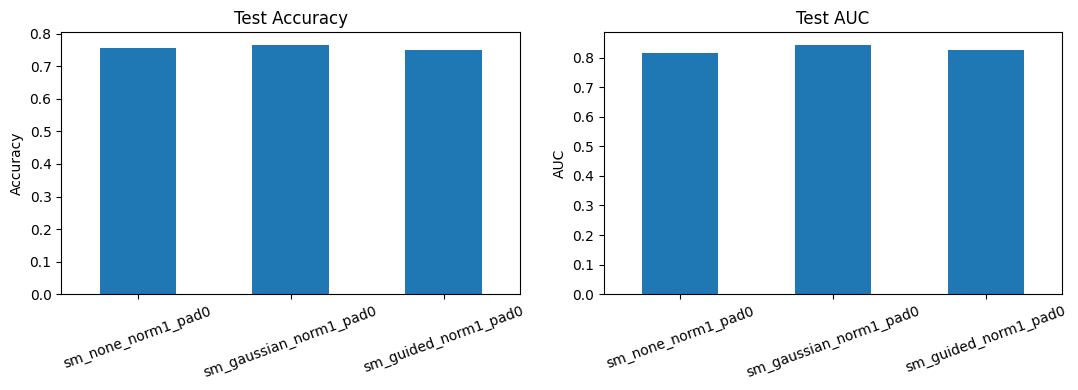

,mode,optimal_th
0,sm_none_norm1_pad0,None
1,sm_gaussian_norm1_pad0,None
2,sm_guided_norm1_pad0,None


In [4]:
# %%
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
BASE_SAVE_DIR = PROJECT_ROOT / "_pilot_ckpt_20250905_162614"  # <- 학습 결과 타임스탬프 폴더로 교체

# 실험 폴더(학습 스크립트에서 만든 디렉토리명과 일치해야 함)
EXPERIMENTS = {
    "sm_none_norm1_pad0":     BASE_SAVE_DIR / "sm_none_norm1_pad0",
    "sm_gaussian_norm1_pad0": BASE_SAVE_DIR / "sm_gaussian_norm1_pad0",
    "sm_guided_norm1_pad0":   BASE_SAVE_DIR / "sm_guided_norm1_pad0",
}

def load_train_results(case_dir: Path):
    """train.py가 저장한 results.json을 읽어 dict 반환 (없으면 None)."""
    p = case_dir / "results.json"
    if p.exists():
        with open(p) as f:
            return json.load(f)
    return None

def find_opt_threshold(eval_dir: Path):
    """
    evaluate 출력 디렉토리에서 최적 임계값을 추정해 반환.
    - results_*.json, metrics_*.json 등을 훑어보고
      ['optimal_threshold','youden_j_threshold','best_threshold','opt_threshold'] 중
      먼저 발견되는 키를 사용.
    - 발견 못하면 None 반환.
    """
    if not eval_dir.exists():
        return None

    # 후보 파일들: results*.json / metrics*.json
    cand_jsons = []
    cand_jsons += glob.glob(str(eval_dir / "results*.json"))
    cand_jsons += glob.glob(str(eval_dir / "metrics*.json"))
    cand_jsons += glob.glob(str(eval_dir / "*.json"))

    keys = ["optimal_threshold", "youden_j_threshold", "best_threshold", "opt_threshold"]

    for jp in sorted(set(cand_jsons)):
        try:
            with open(jp) as f:
                data = json.load(f)
            # 맨 위에 있으면 바로 사용
            for k in keys:
                if k in data and isinstance(data[k], (int, float)):
                    return float(data[k])
            # 혹시 내부에 metrics 섹션이 있으면 거기서도 탐색
            if "metrics" in data and isinstance(data["metrics"], dict):
                for k in keys:
                    if k in data["metrics"] and isinstance(data["metrics"][k], (int, float)):
                        return float(data["metrics"][k])
        except Exception:
            pass
    return None

rows = []
for mode, case_dir in EXPERIMENTS.items():
    train_res = load_train_results(case_dir)
    eval_dir  = case_dir / "eval_outputs"
    opt_th    = find_opt_threshold(eval_dir)

    if train_res is None:
        print(f"[WARN] {mode}: results.json을 찾지 못했습니다 → {case_dir}")
        continue

    rows.append({
        "mode": mode,
        "test_loss":     train_res.get("test_loss", None),
        "test_acc":      train_res.get("test_acc", None),
        "test_auc":      train_res.get("test_auc", None),
        "best_val_loss": train_res.get("best_val_loss", None),
        "optimal_th":    opt_th,
    })

df = pd.DataFrame(rows)

# 표시용 정렬(원하면 주석 해제)
# df = df.sort_values("test_auc", ascending=False)

display(df)

# ---------- Plot ----------
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Accuracy bar
df.plot(x="mode", y="test_acc", kind="bar", ax=axes[0], legend=False, title="Test Accuracy")
axes[0].set_xlabel("")
axes[0].set_ylabel("Accuracy")
axes[0].tick_params(axis="x", rotation=20)

# AUC bar
df.plot(x="mode", y="test_auc", kind="bar", ax=axes[1], legend=False, title="Test AUC")
axes[1].set_xlabel("")
axes[1].set_ylabel("AUC")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

# (선택) 최적 임계값을 별도 표로 보기
if "optimal_th" in df.columns:
    display(df[["mode", "optimal_th"]])
